# English speech emotion recognition (SER) :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **imports:**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from IPython.display import Audio
import librosa   # Audio preprocessing package
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pydub import AudioSegment

In [4]:
from keras.layers import Dense,Dropout,LSTM,TimeDistributed,Flatten,BatchNormalization , Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Conv1D
from keras.optimizers import Adam  # optimization technique
from keras.callbacks import ReduceLROnPlateau , EarlyStopping , TensorBoard , ModelCheckpoint
from keras.models import load_model
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle

# **data collection:**

In [ ]:
!unzip /content/speech-emotion-recognition-ravdess-data.zip

Archive:  /content/speech-emotion-recognition-ravdess-data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/speech-emotion-recognition-ravdess-data.zip or
        /content/speech-emotion-recognition-ravdess-data.zip.zip, and cannot find /content/speech-emotion-recognition-ravdess-data.zip.ZIP, period.


In [7]:
path : str= '/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/'

def load_data(path):
    f_emotions:list[str] = []
    f_pathes:list[str] = []

    folders = os.listdir(path)
    for folder in tqdm(folders,desc='gathering folders:'):
        files = os.listdir(path+folder)
        for file in tqdm(files,desc='gathering files:'):
            step = file.split('.')[0]
            step = step.split('-')[2]
            f_emotions.append(int(step))
            f_pathes.append(path+folder+os.sep+file)
    return [f_emotions,f_pathes]

# **data pre-processing and visualization:**(and data augmentation)

In [8]:
def get_emotion(number):
    info:dict={1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
    return info[number]

def read_audio(path):
    data,sample_rate = librosa.load(path,duration=2.4,offset=0.6)
    return data,sample_rate

def draw_wave(path,data,sr):
    # data , sr = librosa.load(path)
    plt.title('audio wave: '+path)
    disp.waveshow(data,sr=sr)
    plt.show()

def draw_spectogram(path,data,sr):
    # data,sr = librosa.load(path)
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(x)
    plt.title('spectogram for wave: '+path)
    disp.specshow(xdb,sr=sr)
    plt.show()

def add_noise(data,sr):
    noise = 0.035*np.random.uniform()*np.amax(data)
    data += noise*np.random.normal(size=data.shape[0])
    return data,sr

def shift(data,sr):
    shift_range = int(np.random.uniform(low=-5,high=5)*1000)
    shifted = np.roll(data,shift_range)
    return shifted,sr

def pitch(data,sr,factor=0.7):
    pitched = librosa.effects.pitch_shift(y=data,sr=sr,n_steps=factor)
    return pitched,sr

def strech(data,sr,rate=0.85):
    streched = librosa.effects.time_stretch(y=data,rate=0.85)

def feature_extraction(data,sr):
    mfcc = librosa.feature.mfcc(y=data,sr=sr)
    return mfcc

def processing_audio(data,sr,options):
    func = random.choice(options)
    if func =='Standard':
        processed = data
    else:
        processed,_ = func(data,sr)
    return processed
#______________________________________________________________________________
def get_features(path):
    data,sample_rate = read_audio(path)
    funcs = ['Standard',add_noise,pitch]

    features:list = []

    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)

    feature =  feature_extraction(func2_data,sample_rate)

    if feature.shape == (20,104):
        features.append(feature)

    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)

    feature =  feature_extraction(func2_data,sample_rate)

    if feature.shape == (20,104):
        features.append(feature)

    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)

    feature =  feature_extraction(func2_data,sample_rate)

    if feature.shape == (20,104):
        features.append(feature)

    get_features.num_of_features = len(features)

    return features
#____________________________________________________________________________________
def display(number):
    data,sample_rate = read_audio(pathes[number])
    mfcc_features = feature_extraction(data,sample_rate)
    print(len(mfcc_features))
    print('emotion ->',get_emotion(emotions[number]))
    # data,sample_rate = add_noise(data,sample_rate)
    data,sample_rate = pitch(data,sample_rate)
    draw_wave(pathes[number],data,sample_rate)
    draw_spectogram(pathes[number],data,sample_rate)
    return data , sample_rate

emotions , pathes = load_data(path)

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 203442.39it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 378433.44it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 330260.16it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 400092.59it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 314966.51it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 268006.65it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 412554.49it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 412554.49it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 383041.46it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 382459.33it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 358487.52it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 341926.96it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 415964.03it/s]

gathering files:: 100%|██████████| 60/60 [00:00<00:00, 423667.07it/s]

gather

**Simple EDA :**

In [11]:
from pydub import AudioSegment
import os

file_path : str= "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav"  # Replace with the path to your MP3 audio file

try:
    if os.path.exists(file_path):
        audio = AudioSegment.from_mp3(file_path)

        num_channels = audio.channels
        sample_width = audio.sample_width
        frame_rate = audio.frame_rate
        num_frames = len(audio)

        print("Audio File Information:")
        print(f"Number of Channels: {num_channels}")
        print(f"Sample Width: {sample_width} bytes")
        print(f"Frame Rate: {frame_rate} Hz")
        print(f"Number of Frames: {num_frames}")

        print("Successfully read audio data.")

    else:
        print("File not found.")

except Exception as e:
    print("Error:", e)

Audio File Information:
Number of Channels: 1
Sample Width: 2 bytes
Frame Rate: 16000 Hz
Number of Frames: 3303
Successfully read audio data.


20
emotion -> fearful


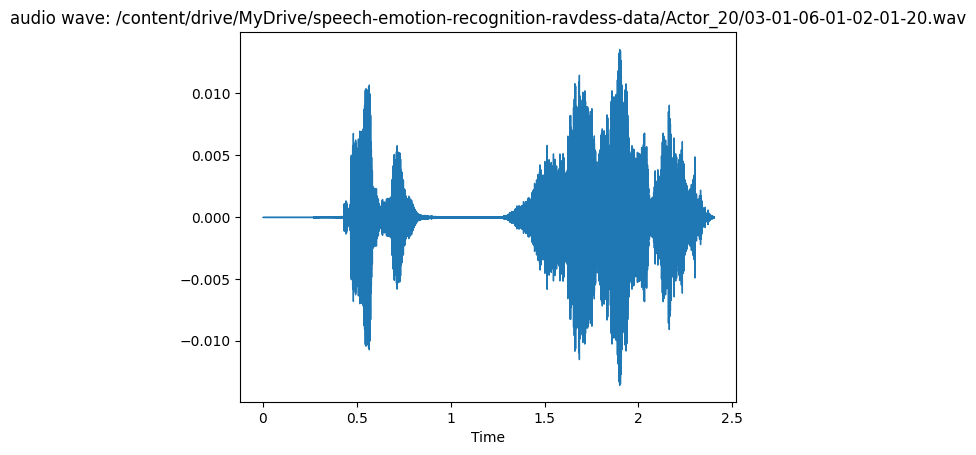

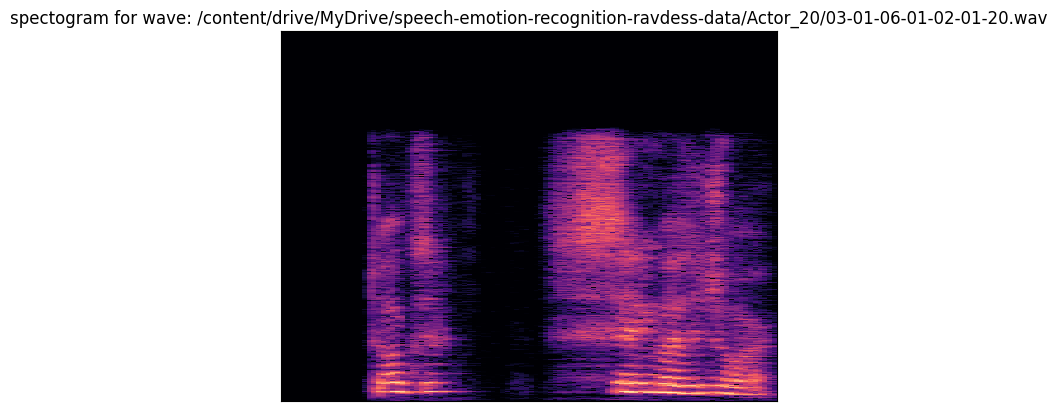

In [12]:
data ,sr = display(40)
Audio(data=data,rate=sr)

In [13]:
from tqdm import tqdm
# takes some time to process
x = []
y = []
for indx in tqdm(range(len(pathes)),desc='extracting features'):
    value = get_features(pathes[indx])
    if value !=[]:
        for item in value:
            x.append(item)
            y.append(np.eye(8)[emotions[indx]-1])

extracting features: 100%|██████████| 1440/1440 [23:00<00:00,  1.04it/s]


# **splitting data phase:**

In [14]:
x_train , x_test , y_train , y_test = train_test_split(np.array(x),np.array(y),
                                                       train_size=0.8,test_size=0.2,
                                                       random_state=42,shuffle=True)

In [15]:
print('train x shape: ',x_train.shape)
print('test x shape: ',x_test.shape)
print('----------------------------------')
print('train y shape: ',y_train.shape)
print('test y shape: ',y_test.shape)

train x shape:  (3451, 20, 104)
test x shape:  (863, 20, 104)
----------------------------------
train y shape:  (3451, 8)
test y shape:  (863, 8)


# post-processing phase:

In [16]:
# expanding and swapping dimensions
train_x = np.expand_dims(x_train,axis=-1)
train_x = np.swapaxes(train_x,1,2)
print('train_x: ',train_x.shape)

test_x = np.expand_dims(x_test,axis=-1)
test_x = np.swapaxes(test_x,1,2)
print('test_x: ',test_x.shape)

inputshape = train_x.shape[1:]

train_x:  (3451, 104, 20, 1)
test_x:  (863, 104, 20, 1)


# **model creation:**

In [17]:
def createmodel(inputshape):
    model = Sequential(name='SEModel')
    model.add(TimeDistributed(Conv1D(32,3,padding='same',activation='relu'),input_shape=inputshape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dense(units=8,activation='softmax'))
    return model


In [18]:
input_shape = train_x.shape[1:]  # (104, 20, 1)

model = createmodel(input_shape)
model.summary()

Model: "SEModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 104, 20, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 104, 20, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 104, 640)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,576 (740.53 KB)

 Trainable params: 189,512 (740.28 KB)

 Non-trainable params: 64 (256.00 B)

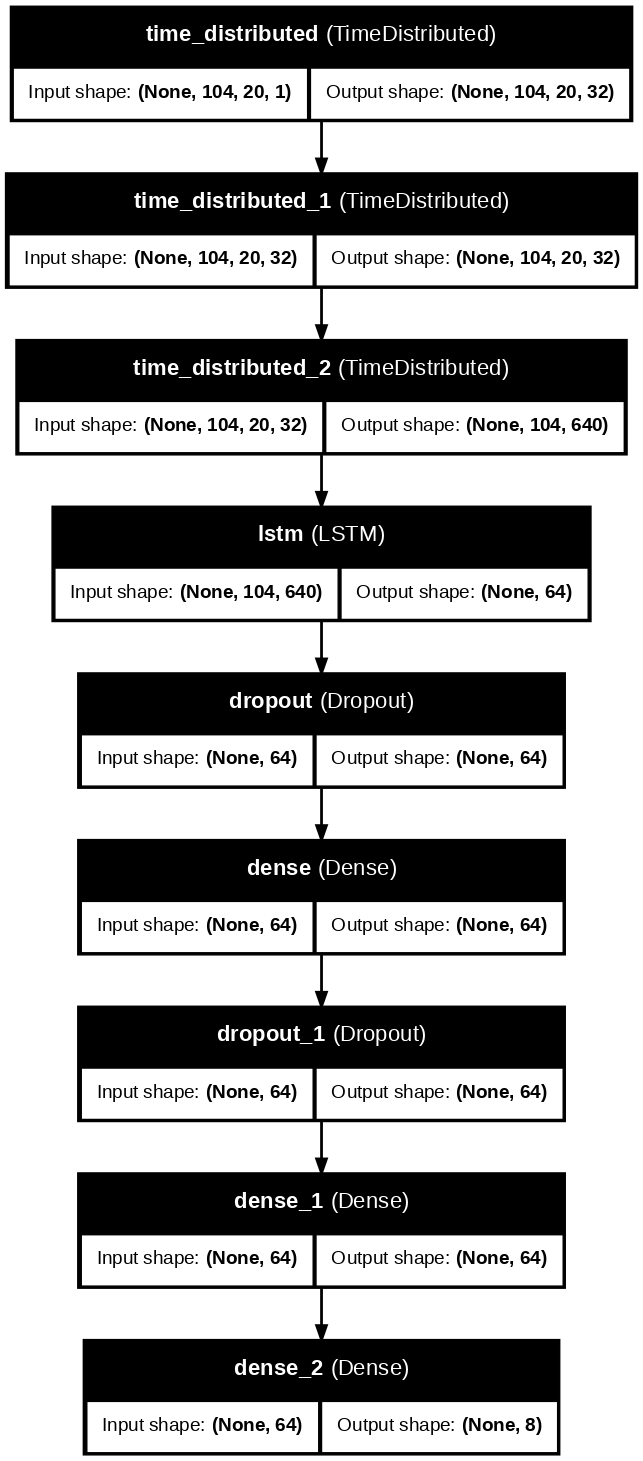

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True ,dpi=100)

# **training phase:**

In [24]:
# also takes some time
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
reduce_ = ReduceLROnPlateau(monitor='val_loss',factor=0.6,verbose=1,patience=5,min_lr=1e-8)  # 1e-8 -> 0.000000001
stop = EarlyStopping(monitor='val_loss',patience=7)
saving = ModelCheckpoint(filepath="best.keras")

history = model.fit(train_x,y_train,batch_size=140,epochs=60,validation_data=(test_x,y_test),callbacks=[reduce_,stop,saving])

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.1705 - loss: 2.0502 - val_accuracy: 0.2700 - val_loss: 1.9330 - learning_rate: 0.0100
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.2371 - loss: 1.9164 - val_accuracy: 0.2607 - val_loss: 1.9288 - learning_rate: 0.0100
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.2561 - loss: 1.8735 - val_accuracy: 0.3001 - val_loss: 1.8399 - learning_rate: 0.0100
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.2948 - loss: 1.7938 - val_accuracy: 0.3105 - val_loss: 1.8303 - learning_rate: 0.0100
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.2979 - loss: 1.7792 - val_accuracy: 0.3314 - val_loss: 1.7563 - learning_rate: 0.0100
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.3325 - loss: 1.7099 - val_accuracy: 0.3592 - val_loss: 1.6901 - learning_rate: 0.0100
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.3482 - loss: 1.6725 -

In [35]:
print('accuracy: ',round(model.evaluate(test_x,y_test)[1]*100),'%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6191 - loss: 1.1150
accuracy:  60 %


In [25]:
# saving model
model.save('model.keras')

# **testing phase (evaluation) :**

### LSTM :

In [27]:
emotion_model = load_model('model.keras')
y_pred = emotion_model.predict(test_x)

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step


In [28]:
weights , biases = model.layers[0].get_weights()
print("first hidden layer weights: \n",weights)
print("\n first hidden layer dimensions:",weights.shape)
print(" \n first hidden layer bias: \n",biases)
print("\n first hidden layer bias dimensions:",biases.shape)

first hidden layer weights: 
 [[[-0.11141851  0.22543472  0.01238487  0.21089572 -0.03002297
   -0.13829187 -0.8966495  -0.5219592   0.30043295  0.08452723
    0.26005793  0.00985189 -0.64174795 -0.11555845 -0.30570045
   -0.05764965  0.00166852 -0.09751617  0.09821445  0.352207
    0.20711206  0.03828786  0.14519434 -0.0672477   0.09041396
    0.2523108   0.1682216  -0.03152769  0.08080659  0.20013906
   -0.05541015  0.09616642]]

 [[ 0.33240303 -0.02025336 -0.8345482  -0.13468857 -0.43183964
   -0.59413654  0.14366153  0.37073883 -0.28547356 -0.68085843
    0.57539654 -0.513684    0.08637577 -0.46894485  0.21910143
   -0.78382623 -0.48052216 -0.38871172  0.6238817   0.37263855
    0.5695196  -0.2293246   0.68079096 -1.0887116  -0.3577536
    0.52216196  0.5679721  -0.2760339  -0.15843439  0.04967532
    0.99601287 -0.09975231]]

 [[ 0.7578067  -1.0692539   0.15145981  0.9181054   0.7220783
    0.413461   -0.16108263 -0.23533915 -0.14799544  0.12397478
   -0.11366399  0.5788552  -0.21

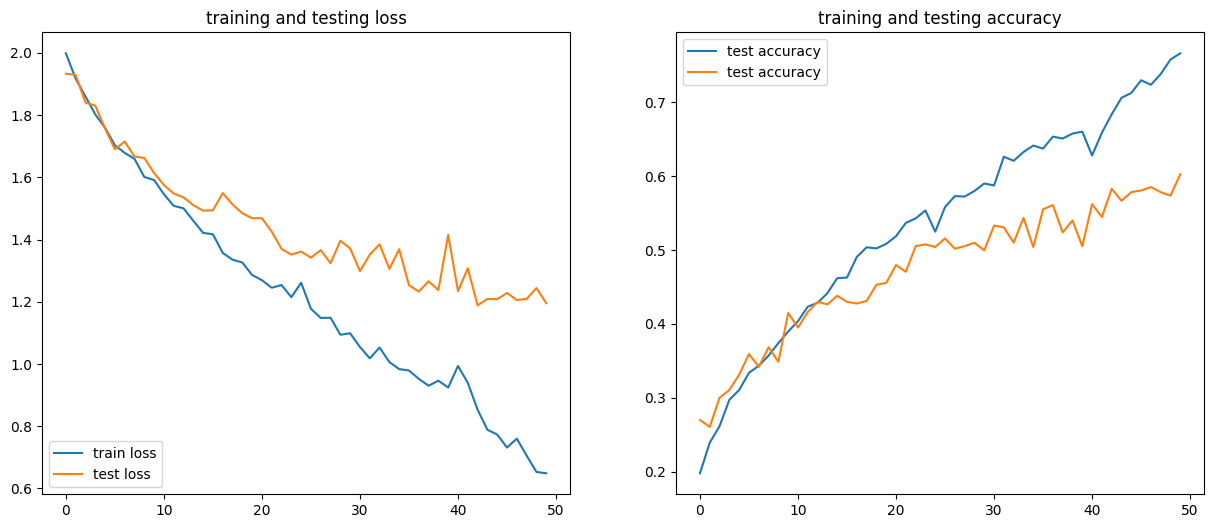

In [29]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
#______________________________________________________________
ax[0].plot(train_loss)
ax[0].plot(test_loss)
ax[0].set_title('training and testing loss')
ax[0].legend(['train loss','test loss'],loc='lower left')
#______________________________________________________________
ax[1].plot(train_accuracy)
ax[1].plot(test_accuracy)
ax[1].set_title('training and testing accuracy')
ax[1].legend(['test accuracy','test accuracy'],loc='upper left')
#______________________________________________________________
plt.show()

In [30]:
encoder = OneHotEncoder()
encoder.fit_transform(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1)).toarray() # 8 classes

pred_y = encoder.inverse_transform(y_pred)
test_y = encoder.inverse_transform(y_test)

emotion_predictions = [get_emotion(value) for value in pred_y.flatten()]
emotion_actual = [get_emotion(value) for value in test_y.flatten()]

df = pd.DataFrame(columns=['actual emotions','predicted emotions'])
df['actual emotions'] = emotion_actual
df['predicted emotions'] = emotion_predictions

df.head(10)

,actual emotions,predicted emotions
0,happy,happy
1,sad,surprised
2,disgust,disgust
3,angry,angry
4,angry,angry
5,disgust,surprised
6,fearful,fearful
7,happy,happy
8,angry,angry
9,surprised,happy


In [31]:
from collections import Counter  # built-in function
classes = Counter(list(df['predicted emotions']))
print(classes)

Counter({'happy': 185, 'angry': 125, 'neutral': 101, 'surprised': 99, 'disgust': 93, 'calm': 91, 'fearful': 86, 'sad': 83})


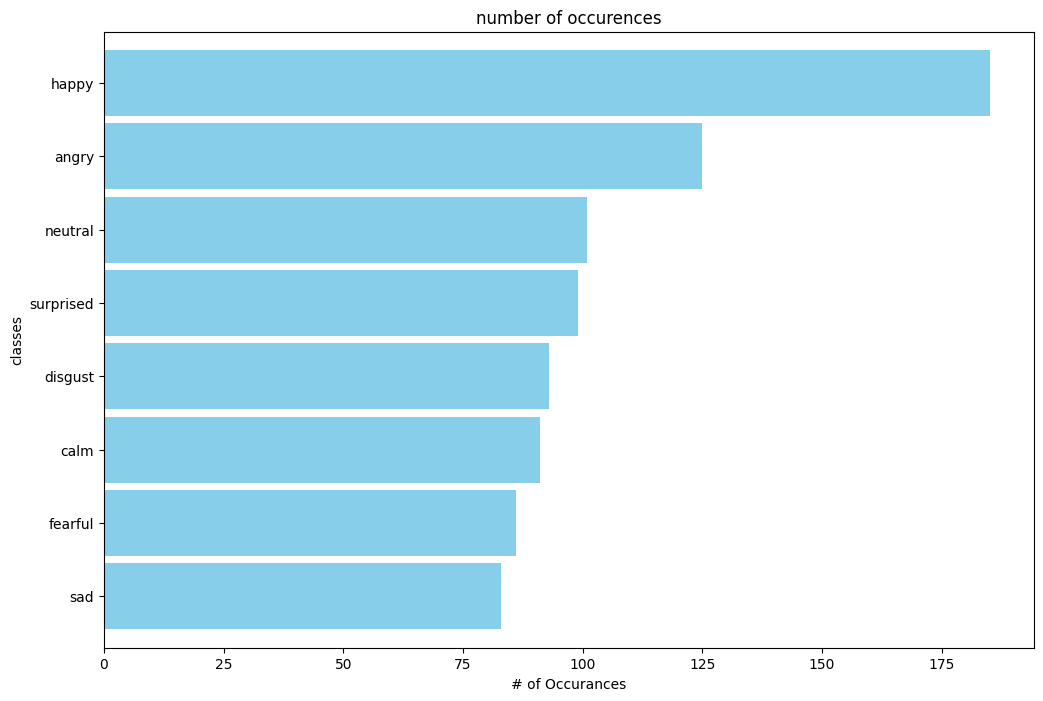

In [32]:
unigrams = (pd.Series(list(df['predicted emotions'])).value_counts())
unigrams.sort_values().plot.barh(color='skyblue', width=.9, figsize=(12, 8))
plt.title('number of occurences')
plt.ylabel('classes')
plt.xlabel('# of Occurances')
plt.show()

# Confusion Matrix :

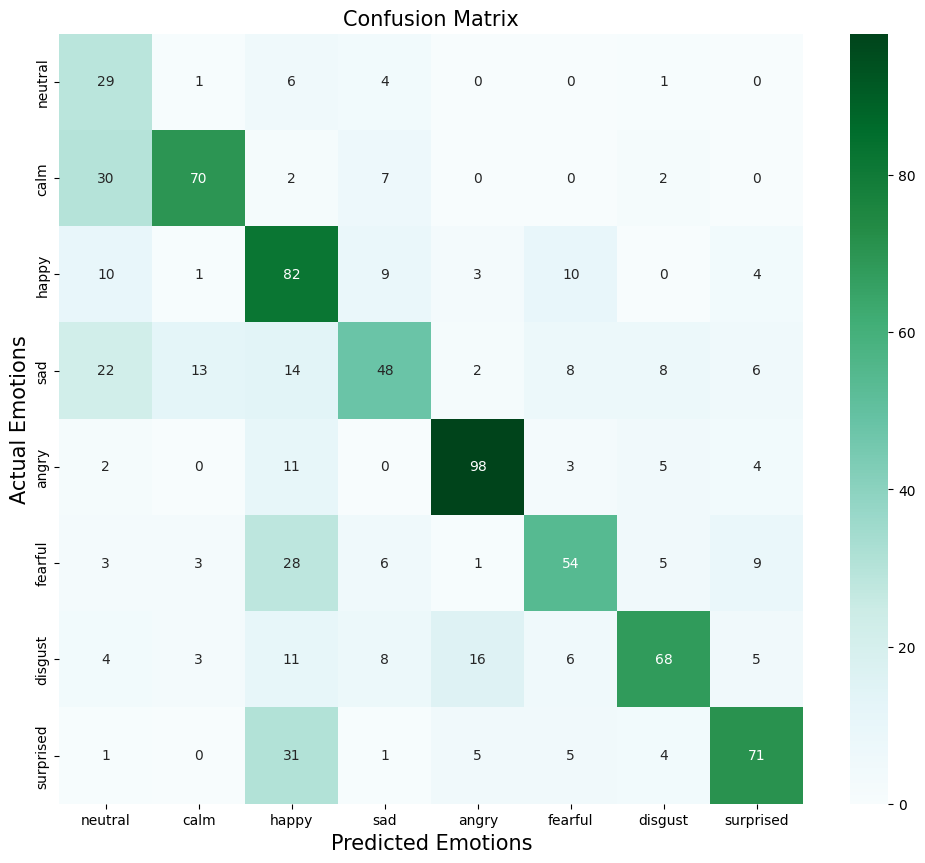

In [33]:
cm =confusion_matrix(test_y,pred_y)

emts = [get_emotion(em) for em in encoder.categories_[0]]

cmt = pd . DataFrame(cm ,index=emts, columns=emts)
plt.figure(figsize=(12,10))
sns.heatmap(cmt,annot=True, fmt='',cmap='BuGn')
plt.title('Confusion Matrix', size = 15)
plt.xlabel('Predicted Emotions', size = 15)
plt.ylabel('Actual Emotions',size=15)
plt.show()

# tensorboard :

In [ ]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

# voice recorder and real-time input:

In [ ]:
import sounddevice
from scipy.io.wavfile import write

def voice_recorder(seconds, file):
    print("Recording Started…")
    recording = sounddevice.rec((seconds * 44100), samplerate= 44100, channels=2)
    sounddevice.wait()
    write(file, 44100, recording)
    print("Recording Finished")

voice_recorder(10, "record.wav")

Recording Started…
Recording Finished


In [38]:
emotion_model = load_model('model.keras')

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# encoder.fit_transform(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1)).toarray()

In [39]:
with open('encoder.pkl','wb') as file:
    pickle.dump(encoder,file)

In [40]:
def emotion_detector(path:str):
    features = get_features(path)
    feat = np.array(features)
    input = np.expand_dims(feat,axis=3)
    input = np.expand_dims(input,axis=3)
    input = np.swapaxes(input,1,2)
    emotion=emotion_model.predict(input)
    pred = encoder.inverse_transform(emotion)
    pred = pred.flatten()
    prediction = [get_emotion(value) for value in pred]
    return prediction[1]

In [43]:
emotion = emotion_detector("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav")
print(emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
neutral
